In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc"
train = pd.read_csv(data_dir + "/train_with_cluster.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [3]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [4]:
def save_importances(importances_, top=True, figname="importances.png"):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    data = importances_.sort_values('mean_gain', ascending=False)[:300] if top else importances_.sort_values('mean_gain', ascending=True)[:300]
    sns.barplot(
        x='gain',
        y='feature',
        data=data)
    plt.tight_layout()
    plt.savefig(figname)


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds, path, figname="confusion_matrix.png"):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    sample_sub = pd.read_csv(path)
    class_names = list(sample_sub.columns[1:-1])
    del sample_sub

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig(figname)

## EDA

In [5]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
0,615,59750.4229,2,-544.810303,3.622952,1,2
1,615,59750.4306,1,-816.434326,5.553370,1,2
2,615,59750.4383,3,-471.385529,3.801213,1,2
3,615,59750.4450,4,-388.984985,11.395031,1,2
4,615,59752.4070,2,-681.858887,4.041204,1,2


In [8]:
train.flux.idxmin()

1353412

In [13]:
flux_val = train.groupby(["object_id", "passband"]).agg({
    "flux": ["std", "mean"]
})
flux_val.columns = pd.Index([e[0] + "_" + e[1] for e in flux_val.columns])
flux_val.reset_index(inplace=True)
flux_val.head()

,object_id,passband,flux_std,flux_mean
0,615,0,83.944735,-3.254554
1,615,1,601.787302,-385.699911
2,615,2,455.121346,-134.146566
3,615,3,335.425053,-121.103501
4,615,4,291.803449,-55.954592


In [14]:
new = pd.merge(train, flux_val, how="left", on=["object_id", "passband"])

In [18]:
new["flux_whitened"] = (new.flux - new.flux_mean) / new.flux_std

In [19]:
new

,object_id,mjd,passband,flux,flux_err,detected,cluster,flux_std,flux_mean,flux_whitened
0,615,59750.4229,2,-544.810303,3.622952,1,2,455.121346,-134.146566,-0.902317
1,615,59750.4306,1,-816.434326,5.553370,1,2,601.787302,-385.699911,-0.715759
2,615,59750.4383,3,-471.385529,3.801213,1,2,335.425053,-121.103501,-1.044293
3,615,59750.4450,4,-388.984985,11.395031,1,2,291.803449,-55.954592,-1.141283
4,615,59752.4070,2,-681.858887,4.041204,1,2,455.121346,-134.146566,-1.203442
5,615,59752.4147,1,-1061.457031,6.472994,1,2,601.787302,-385.699911,-1.122917
6,615,59752.4224,3,-524.954590,3.552751,1,2,335.425053,-121.103501,-1.203998
7,615,59752.4334,4,-393.480225,3.599346,1,2,291.803449,-55.954592,-1.156688
8,615,59752.4435,5,-355.886780,10.421921,1,2,294.779522,-47.449847,-1.046331
9,615,59767.2968,2,-548.013550,3.462291,1,2,455.121346,-134.146566,-0.909355


In [26]:
target42 = meta.query("target == 42")
train42 = train.query("object_id in @target42.object_id")
train42.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
702,730,59798.3205,2,1.177371,1.364300,0,1
703,730,59798.3281,1,2.320849,1.159247,0,1
704,730,59798.3357,3,2.939447,1.771328,0,1
705,730,59798.3466,4,2.128097,2.610659,0,1
706,730,59798.3576,5,-12.809639,5.380097,0,1


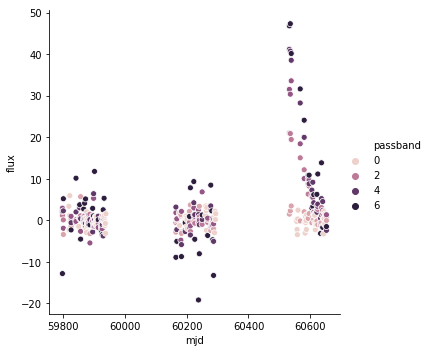

In [27]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train42.query("object_id == 730"))

In [31]:
train42.query("object_id == 730").reset_index().flux.idxmax()

231

In [52]:
obj730 = train42.query("object_id == 730")

In [53]:
obj730.reset_index(inplace=True)

In [41]:
fcp = {
    'fft_coefficient': [{
        'coeff': 0,
        'attr': 'abs'
    }, {
        'coeff': 1,
        'attr': 'abs'
    }]
}
df_ts = extract_features(
    obj730[:210],
    column_id='object_id',
    column_sort='mjd',
    column_kind='passband',
    column_value='flux',
    default_fc_parameters=fcp,
    n_jobs=2
)

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 686.26it/s]


In [54]:
obj730[231:].flux

231    47.310059
232    19.450977
233     3.462672
234    33.572102
235    38.518837
236    40.146099
237     0.190944
238     0.098122
239    -0.253067
240    -2.200897
241    -3.459960
242     0.328893
243     2.453341
244    15.044784
245    -0.142653
246    18.416132
247    28.234451
248    31.623583
249    12.164557
250     2.065962
251    10.053763
252    19.975168
253    24.093925
254    -0.473370
255    -3.070249
256     0.970706
257    -0.533032
258    -0.049936
259    -2.202578
260     1.361049
         ...    
300     3.270966
301     3.910560
302    11.152599
303     0.461658
304    -1.166283
305    -0.607413
306     0.497926
307    -3.150459
308     3.090597
309    -0.513601
310     1.251243
311     5.235262
312    13.844719
313     1.619818
314    -1.366803
315     2.428993
316     4.530898
317    -1.690480
318     0.405838
319    -3.248368
320     2.105939
321     0.427463
322    -1.030916
323    -0.756102
324     1.493417
325     0.858392
326    -0.048933
327     1.3480

In [61]:
maxdf = train.groupby("object_id").agg({
    "flux": "idxmax"
})
maxdf.rename(columns={"flux": "flux_idxmax"}, inplace=True)
with_maxdf = pd.merge(train, maxdf, how='left', on='object_id')

In [69]:
with_maxdf["index_"] = with_maxdf.index

In [73]:
with_maxdf["index_diff"] = with_maxdf.index_ - with_maxdf.flux_idxmax

In [76]:
from_max100 = with_maxdf.query("index_diff >= 0 & index_diff < 100")

In [79]:
obj730_ = from_max100.query("object_id == 730")

In [78]:
obj730_

,object_id,mjd,passband,flux,flux_err,detected,cluster,flux_idxmax,index_,index_diff
933,730,60535.3177,5,47.310059,7.197146,1,0,933,933,0
934,730,60538.2826,2,19.450977,1.865142,1,0,933,934,1
935,730,60538.2903,1,3.462672,2.695356,0,0,933,935,2
936,730,60538.2980,3,33.572102,1.944897,1,0,933,936,3
937,730,60538.3089,4,38.518837,2.334413,1,0,933,937,4
938,730,60538.3199,5,40.146099,5.039364,1,0,933,938,5
939,730,60554.2651,0,0.190944,2.266587,0,0,933,939,6
940,730,60555.2411,0,0.098122,2.049620,0,0,933,940,7
941,730,60556.2370,0,-0.253067,2.551228,0,0,933,941,8
942,730,60557.2322,0,-2.200897,1.848830,0,0,933,942,9


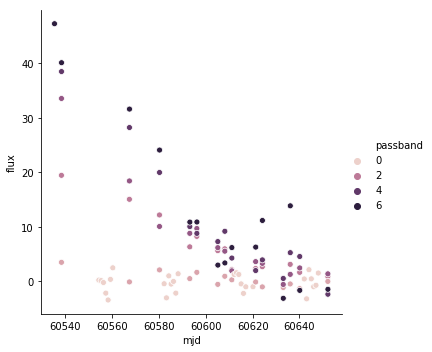

In [80]:
sns.relplot(x='mjd', y='flux', hue='passband', data=obj730_)

In [82]:
obj730_.loc[:, "flux"] -= obj730_.flux.min()

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [86]:
obj730_["log_flux"] = np.log(obj730_["flux"] + 0.01)

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


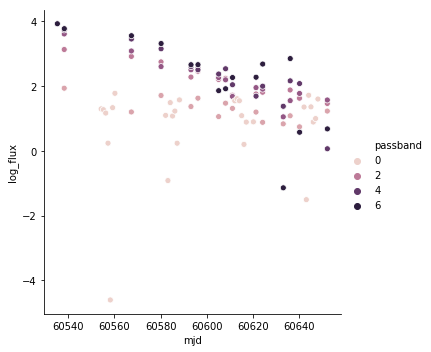

In [88]:
sns.relplot(x='mjd', y='log_flux', hue='passband', data=obj730_)

In [89]:
extract_features(
    obj730_,
    column_id="object_id",
    column_sort="mjd",
    column_kind="passband",
    column_value="log_flux",
    default_fc_parameters={
        'linear_trend': [{
            "attr": "pvalue"
        }, {
            "attr": "rvalue"
        }, {
            "attr": "slope"
        }, {
            "attr": "intercept"
        }, {
            "attr": "stderr"
        }]
    }
)

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 472.07it/s]


variable,"0__linear_trend__attr_""intercept""","0__linear_trend__attr_""pvalue""","0__linear_trend__attr_""rvalue""","0__linear_trend__attr_""slope""","0__linear_trend__attr_""stderr""","1__linear_trend__attr_""intercept""","1__linear_trend__attr_""pvalue""","1__linear_trend__attr_""rvalue""","1__linear_trend__attr_""slope""","1__linear_trend__attr_""stderr""",...,"4__linear_trend__attr_""intercept""","4__linear_trend__attr_""pvalue""","4__linear_trend__attr_""rvalue""","4__linear_trend__attr_""slope""","4__linear_trend__attr_""stderr""","5__linear_trend__attr_""intercept""","5__linear_trend__attr_""pvalue""","5__linear_trend__attr_""rvalue""","5__linear_trend__attr_""slope""","5__linear_trend__attr_""stderr"""
id,,,,,,,,,,,,,,,,,,,,,
730,0.449982,0.401351,0.165028,0.026126,0.030621,1.648816,0.003243,-0.726649,-0.05953,0.016247,...,3.491237,0.000069,-0.863691,-0.18781,0.031639,3.848127,0.001381,-0.746757,-0.227151,0.056111


In [90]:
mindf = with_maxdf.groupby("object_id").agg({
    "flux": "min"
})
mindf.rename(columns={"flux": "flux_min"}, inplace=True)
with_maxdf = pd.merge(with_maxdf, mindf, how="left", on="object_id")
with_maxdf["flux"] = with_maxdf["flux"] - with_maxdf["flux_min"]

In [93]:
with_maxdf["log_flux"] = np.log(with_maxdf["flux"] + 0.01)

In [95]:
ex = extract_features(
    with_maxdf,
    column_id="object_id",
    column_sort="mjd",
    column_kind="passband",
    column_value="log_flux",
    default_fc_parameters={
        'linear_trend': [{
            "attr": "pvalue"
        }, {
            "attr": "rvalue"
        }, {
            "attr": "slope"
        }, {
            "attr": "intercept"
        }, {
            "attr": "stderr"
        }]
    }
)

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  4.80it/s]


In [96]:
ex

variable,"0__linear_trend__attr_""intercept""","0__linear_trend__attr_""pvalue""","0__linear_trend__attr_""rvalue""","0__linear_trend__attr_""slope""","0__linear_trend__attr_""stderr""","1__linear_trend__attr_""intercept""","1__linear_trend__attr_""pvalue""","1__linear_trend__attr_""rvalue""","1__linear_trend__attr_""slope""","1__linear_trend__attr_""stderr""",...,"4__linear_trend__attr_""intercept""","4__linear_trend__attr_""pvalue""","4__linear_trend__attr_""rvalue""","4__linear_trend__attr_""slope""","4__linear_trend__attr_""stderr""","5__linear_trend__attr_""intercept""","5__linear_trend__attr_""pvalue""","5__linear_trend__attr_""rvalue""","5__linear_trend__attr_""slope""","5__linear_trend__attr_""stderr"""
id,,,,,,,,,,,,,,,,,,,,,
615,6.984541,4.292204e-01,0.101370,0.000422,0.000531,5.202336,2.798180e-01,0.144304,0.017890,0.016393,...,6.720861,1.874472e-03,0.399816,0.006712,0.002056,6.737136,0.003858,0.376857,0.006516,0.002160
713,3.321610,1.461049e-08,-0.615147,-0.032704,0.005083,3.192804,1.144548e-13,-0.801663,-0.024781,0.002515,...,3.228556,3.875745e-11,-0.746808,-0.026983,0.003270,3.078023,0.000010,-0.553385,-0.026834,0.005496
730,2.950995,8.104468e-01,-0.028764,-0.000131,0.000543,2.946196,6.442761e-01,0.065555,0.000401,0.000864,...,2.886292,1.045509e-02,0.355543,0.008086,0.003037,2.719551,0.486819,0.099599,0.007893,0.011265
745,2.931682,1.412336e-02,-0.288101,-0.002999,0.001191,2.935126,6.612916e-01,-0.059845,-0.001474,0.003346,...,3.148935,4.674685e-01,-0.099092,-0.007341,0.010032,2.985389,0.976588,0.004050,0.000174,0.005913
1124,2.757826,1.108154e-02,0.318037,0.002517,0.000961,2.718049,4.739066e-06,0.560539,0.009961,0.001967,...,2.145152,1.004951e-03,0.420803,0.028426,0.008189,2.634048,0.012818,0.327747,0.011318,0.004399
1227,2.525309,3.822093e-01,0.104529,0.001417,0.001611,2.546761,8.459809e-01,0.027603,0.000220,0.001124,...,2.523165,7.684360e-01,0.042256,0.000892,0.003012,1.814209,0.077945,0.249101,0.018507,0.010279
1598,2.168592,1.419309e-05,0.517264,0.021404,0.004534,2.333245,1.372668e-02,0.321926,0.016375,0.006435,...,2.410744,1.886281e-02,0.307519,0.013570,0.005611,2.287674,0.530065,0.084899,0.007108,0.011249
1632,2.703795,3.285021e-01,-0.125128,-0.000953,0.000968,2.701805,4.021681e-01,-0.112096,-0.000824,0.000976,...,3.138197,3.071904e-08,-0.651401,-0.011134,0.001733,3.543397,0.002415,-0.394169,-0.026998,0.008488
1920,2.720897,7.288763e-01,-0.066020,-0.002460,0.007026,2.994383,6.404214e-01,-0.071557,-0.004086,0.008686,...,2.979862,8.447879e-01,0.030022,0.002182,0.011079,2.182352,0.129969,0.229160,0.027075,0.017538
